# Data gen

By: Abhinav Vedmala, Nikhil Ghate, Om Pathak (Team NOA)

Have you ever wondered what factors go into loan approval, and whether or not you would qualify? When a loan application is submitted, the bank looks at information such as income, credit score, employment, and debt-to-income ratio.

We found a dataset that describes loan applicant information, and whether or not they got approved. The goal of our project is to perform  exploratory data analysis to determine whether some factors are more relevant than others when it comes to loan approval. We will also explore topics such as hot-encoding, imputation, and synthetic data generation.

Here are links to resources and tools we used for our project:
- [DataProfiler](https://capitalone.github.io/DataProfiler/docs/0.7.7/html/index.html)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [Numpy](https://numpy.org/doc/)
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/)
- [Seaborn](https://seaborn.pydata.org/)
- [missingpy](https://github.com/epsilon-machine/missingpy)
- [sklearn](https://scikit-learn.org/stable/)

In [1]:
import dataprofiler as dp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys 
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

from scipy import stats
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.svm import SVC

## Data Collection and Curation

#### Loading Data 

In [2]:
data = pd.read_csv("loan_approval_data.csv")
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


Let's take a closer look at the categorical variables so we can figure out what we need to re-encode later on. 

In [3]:
# recognizing all the categorical variables 
cat_vars = ["Gender", "Married", "Education", "Self_Employed", "Property_Area", "Loan_Status", "Dependents", "Credit_History"] 

# checking number of unique values for each categorial variable 
for var in cat_vars: 
    print(data[var].unique())

['Male' 'Female' nan]
['No' 'Yes' nan]
['Graduate' 'Not Graduate']
['No' 'Yes' nan]
['Urban' 'Rural' 'Semiurban']
['Y' 'N']
['0' '1' '2' '3+' nan]
[ 1.  0. nan]


We don't need the LoanID column, so we can drop it.

In [4]:
data = data.drop(['Loan_ID'], axis=1)

## Exploratory Data Analysis

We will generate plots for each column/variable. We will use histograms for categorical variables and violin plots for quantitative variables. 

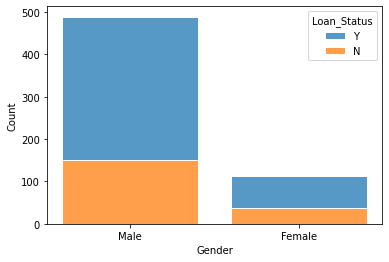

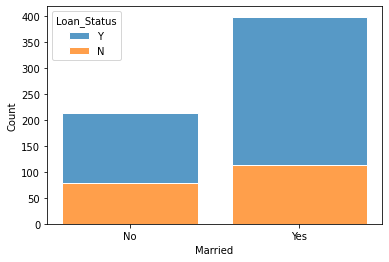

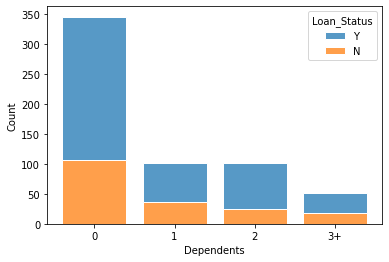

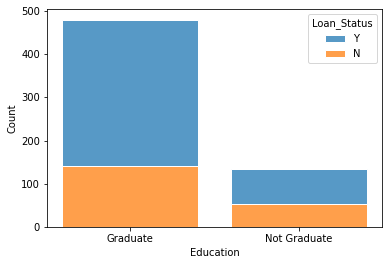

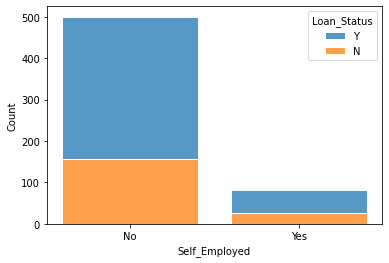

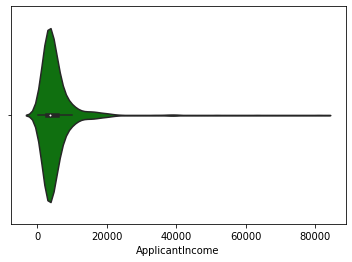

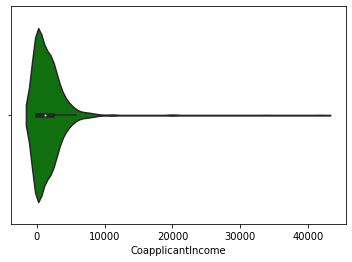

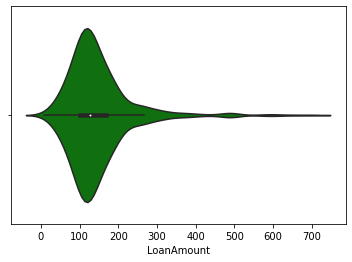

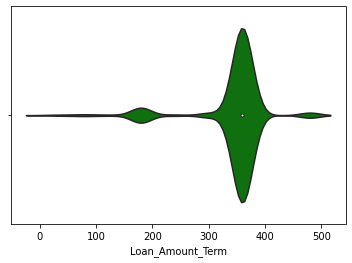

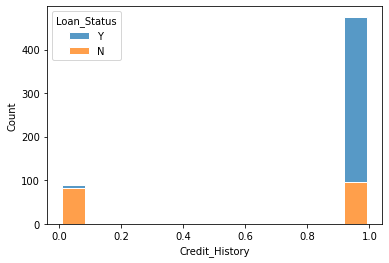

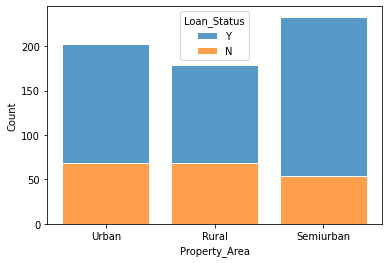

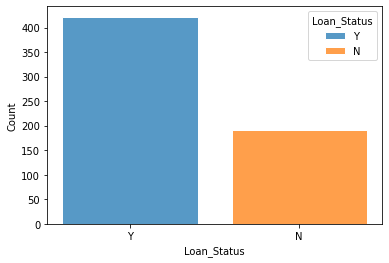

In [5]:
for col in data.columns:
    if len(data[col].value_counts()) < 10:
        #sns.histplot(data=data, x=col, hue = "Loan_Status")
        sns.histplot(
            data,
            x=col,
            # Use the value variable here to turn histogram counts into weighted
            # values.
            hue='Loan_Status',
            multiple='stack',
            # Add white borders to the bars.
            edgecolor='white',
            # Shrink the bars a bit so they don't touch.
            shrink=0.8
        )
    else:
        sns.violinplot(data=data, x=col, color = 'green')
    plt.show()

Some observations from the visual interpretation of the graphs
- More male applicants than female applicants
- More married applicants than unmarried, though the gap is not as wide as female vs male applicants
- More graduates than non-graduates
- Most applicants have 0 dependents
- More non-self employed applicants than self-employed applicants
- The most common loan amount term is 30 years by alot, the second most common being 15 years
- Pretty even distribution of property areas, with the most frequent being semiurban, then urban, and then rural
- Loan amount and applicant amounts are heavily right-skewed
- Alot of coapplicants have 0 income

Some charts like the loan amounts and applicant incomes are heavily right skewed, and contain outliers. Let's redo these charts after removing the outliers

Below are the applicants with an applicant income of over 30000. As you can see, there are only a few applicants that are in this range. 

In [6]:
data.loc[data["ApplicantIncome"] > 30000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
155,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
171,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
183,Male,Yes,1,Graduate,No,33846,0.0,260.0,360.0,1.0,Semiurban,N
185,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y
333,Male,Yes,0,Graduate,NaN,63337,0.0,490.0,180.0,1.0,Urban,Y
409,Male,Yes,3+,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N
443,Male,No,1,Graduate,No,37719,0.0,152.0,360.0,1.0,Semiurban,Y


Let's regenerate our violin plot excluding applicants with income over 30000.

<AxesSubplot:xlabel='ApplicantIncome'>

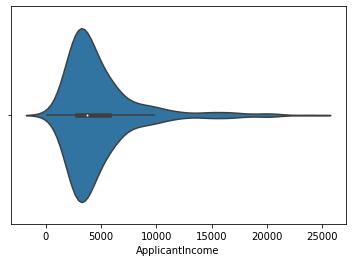

In [7]:
sns.violinplot(data=data[data["ApplicantIncome"] < 30000], x="ApplicantIncome")

Let's filter out applicants with a loan amount over 400. 

In [8]:
data.loc[data["LoanAmount"] > 400]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
130,Male,No,0,Graduate,Yes,20166,0.0,650.0,480.0,NaN,Urban,Y
155,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
171,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
177,Male,Yes,3+,Graduate,No,5516,11300.0,495.0,360.0,0.0,Semiurban,N
278,Male,Yes,0,Graduate,No,14583,0.0,436.0,360.0,1.0,Semiurban,Y
308,Male,No,0,Graduate,No,20233,0.0,480.0,360.0,1.0,Rural,N
333,Male,Yes,0,Graduate,NaN,63337,0.0,490.0,180.0,1.0,Urban,Y
369,Male,Yes,0,Graduate,No,19730,5266.0,570.0,360.0,1.0,Rural,N
432,Male,No,0,Graduate,NaN,12876,0.0,405.0,360.0,1.0,Semiurban,Y
487,Male,Yes,1,Graduate,No,18333,0.0,500.0,360.0,1.0,Urban,N


<AxesSubplot:xlabel='LoanAmount'>

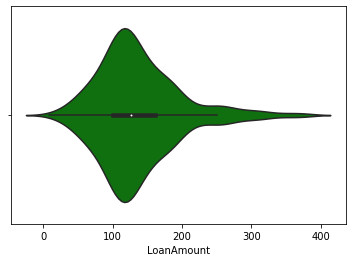

In [9]:
sns.violinplot(data=data[data["LoanAmount"] < 400], x="LoanAmount", color = 'green')

Let's filter out applicants with coapplicant incomes over 10000.

In [10]:
data.loc[data["CoapplicantIncome"] > 10000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
9,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
177,Male,Yes,3+,Graduate,No,5516,11300.0,495.0,360.0,0.0,Semiurban,N
402,Male,No,0,Graduate,No,2500,20000.0,103.0,360.0,1.0,Semiurban,Y
417,Male,Yes,2,Graduate,Yes,1600,20000.0,239.0,360.0,1.0,Urban,N
581,Male,No,0,Graduate,No,1836,33837.0,90.0,360.0,1.0,Urban,N
600,Female,No,3+,Graduate,NaN,416,41667.0,350.0,180.0,NaN,Urban,N


<AxesSubplot:xlabel='CoapplicantIncome'>

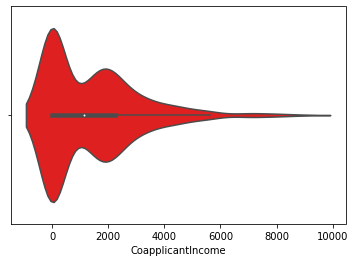

In [11]:
sns.violinplot(data=data[data["CoapplicantIncome"] < 10000], x="CoapplicantIncome", color='red')

Let's start looking at the relationships between two variables

Below, we will compare the loan amount and applicant income. We will distinguish between applicants who got approved and applicants who did not get approved. Looking at the plot, we can see that generally applicants with high loan amounts and high applicant incomes get approved. 

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

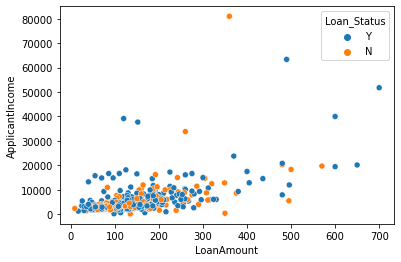

In [12]:
sns.scatterplot(y="ApplicantIncome", x="LoanAmount", data=data,  hue="Loan_Status") 

Again, let's filter out some outliers. Let's filter out applicants who's applicant income is less than 7500. The data looks pretty random, so it's hard to see any trends visually.

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

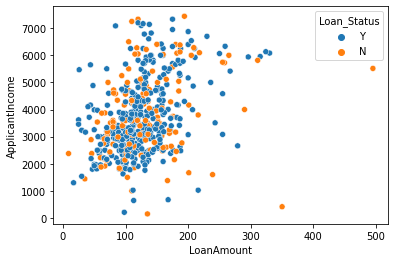

In [13]:
sns.scatterplot(y="ApplicantIncome", x="LoanAmount", data=data[data["ApplicantIncome"] < 7500], hue="Loan_Status") 

Let's add a regression line.

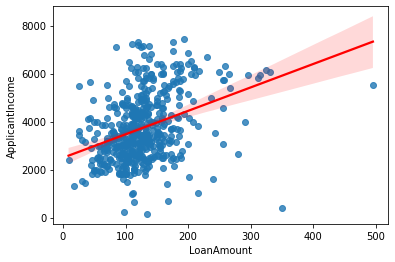

In [14]:
p = sns.regplot(y="ApplicantIncome", x="LoanAmount", data=data[data["ApplicantIncome"] < 7500], line_kws={"color": "red"})

x = p.get_lines()[0].get_xdata()
y = p.get_lines()[0].get_ydata()

In [15]:
print(x[:5])
print(y[:5])

[ 9.         13.90909091 18.81818182 23.72727273 28.63636364]
[2577.43518239 2625.43161249 2673.42804258 2721.42447268 2769.42090277]


In [16]:
# slope of the regression line 
corr_val = (y[1] - y[0]) / (x[1] - x[0])
# y-intercept of the regression line
y_int = y[0] - (corr_val * x[0]) 
print(f"The correlation value is {corr_val} and the y-intercept is {y_int}")

The correlation value is 9.777050574767632 and the y-intercept is 2489.441727222022


Applicant income represents monthly income in dollars, and loan amount represents the loan amount in thousands of dollars. We can interpret the slope of the regression line as follows: For every thousand dollar increase in the loan amount, there is a $9.78 rise in monthly applicant income. This might not seem right at first, but these are loan amounts for mortgages, which is why they're so big. 

## Preparing the Data for Further Analysis

### Hot Encoding

We need to hot encode the categorical data variables so we can apply ML algorithms to this dataset. First, lets see how many unique fields exist for each categorical variable. One issue before we start is with the NaN values. They're tricky to map and work with so we'll temporary replace them with None.

In [17]:
data = data.replace({np.nan: None})

In [18]:
for var in cat_vars: 
    print(data[var].unique().tolist())

['Male', 'Female', None]
['No', 'Yes', None]
['Graduate', 'Not Graduate']
['No', 'Yes', None]
['Urban', 'Rural', 'Semiurban']
['Y', 'N']
['0', '1', '2', '3+', None]
[1.0, 0.0, None]


Let's map each categorical variable's value to an integer. The following dictionary shows the categorical variables' new mappings.

In [19]:
hot_encode = {}

for cat_var in cat_vars:
    for i, var in enumerate(data[cat_var].unique().tolist()):
        hot_encode[var] = i

# Keeping the missing values so we can impute them later
hot_encode[None] = None 
hot_encode

{'0': 0,
 0.0: 1,
 '1': 1,
 1.0: 0,
 '2': 2,
 '3+': 3,
 'Female': 1,
 'Graduate': 0,
 'Male': 0,
 'N': 1,
 'No': 0,
 None: None,
 'Not Graduate': 1,
 'Rural': 1,
 'Semiurban': 2,
 'Urban': 0,
 'Y': 0,
 'Yes': 1}

Doing the actual encoding

In [20]:
for cat_var in cat_vars:
    new_col = []
    
    for _, row in data.iterrows():
        new_col.append(hot_encode[row[cat_var]])
    
    data[cat_var] = new_col

In [21]:
data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,0.0,0.0,0,0.0,5849,0.0,None,360.0,0.0,0,0
1,0.0,1.0,1.0,0,0.0,4583,1508.0,128.0,360.0,0.0,1,1
2,0.0,1.0,0.0,0,1.0,3000,0.0,66.0,360.0,0.0,0,0
3,0.0,1.0,0.0,1,0.0,2583,2358.0,120.0,360.0,0.0,0,0
4,0.0,0.0,0.0,0,0.0,6000,0.0,141.0,360.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,1.0,0.0,0.0,0,0.0,2900,0.0,71.0,360.0,0.0,1,0
610,0.0,1.0,3.0,0,0.0,4106,0.0,40.0,180.0,0.0,1,0
611,0.0,1.0,1.0,0,0.0,8072,240.0,253.0,360.0,0.0,0,0
612,0.0,1.0,2.0,0,0.0,7583,0.0,187.0,360.0,0.0,0,0


As you can see, all the categorical variables have been hot-encoded into integers.

### Imputation

Let's count the NaNs in each column.

In [22]:
for col in data.columns: 
    print(col, data[col].isna().sum())

Gender 13
Married 3
Dependents 15
Education 0
Self_Employed 32
ApplicantIncome 0
CoapplicantIncome 0
LoanAmount 22
Loan_Amount_Term 14
Credit_History 50
Property_Area 0
Loan_Status 0


In [23]:
# number of rows with NaN
data.isnull().values.ravel().sum()

149

149 out of 614 of our rows have NaN values so we don't want to simply drop them. That would mean losing a lot of data. This leaves the option of imputing the missing values. The straightforward approach is to use mode and mean imputing. However, this approach will not preserve the relationship among variables and may decrease the variance.

We will be using MissForest which imputes missing values using Random Forests in an iterative fashion. One cool feature with MissForest is that it can handle both categorical and continous variables provided that the categorical variables are hot-encoded which we just did.

In [24]:
imputer = MissForest() 
X_imputed = imputer.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 0


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 1


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 2


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 3


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 4


In [25]:
data_imputed = pd.DataFrame(X_imputed, columns=data.columns)

In [26]:
# lets round off values in categorical columns (0/1 columns)
for cat_var in cat_vars:
    data_imputed = data_imputed.round({cat_var: 0})

data_imputed

Now we have a complete dataset that's been encoded and imputed with no missing data! Let's look at a heatmap of a correlation to identify relationships between variables now that all the data has been prepared.

<AxesSubplot:>

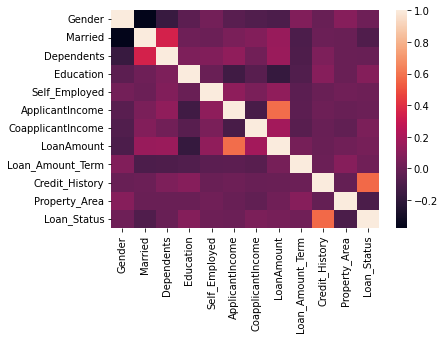

In [27]:
sns.heatmap(data_imputed.corr())

Based on the heatmap above, we can see which variables are closely related. We can tell that credit history, applicant income, and number of dependents are the most important factors in determining whether an application will get approved or not. This makes sense because people with longer credit history and higher income are less likely to default on loans. This also confirms the hypothesis made in the exploratory data analysis section based on the charts we generated. 

## Synthetic Data Generation

In the next step, we will try to generate a synthetic dataset that mimics our real data.

Synthetic data is annotated information that computer simulations or algorithms generate as an alternative to real-world data. It may be artificial, but synthetic data reflects real-world data, mathematically or statistically. Research demonstrates it can be as good or even better for training an AI model than data based on actual objects, events or people.

Why is it so important? Developers need large, carefully labeled datasets to train neural networks. More diverse training data generally makes for more accurate AI models. The problem is gathering and labeling datasets that may contain a few thousand to tens of millions of elements is time consuming and often prohibitively expensive. Enter synthetic data. A single image that could cost $6 from a labeling service can be artificially generated for six cents, estimates Paul Walborsky, who co-founded one of the first dedicated synthetic data services, AI.Reverie.

We are using the DataProfiler which is a tool that can profile dataset and quantify both global and local statistics about the data. At the global level, we have information such as the Correlation matrix, number of rows, ratio of NaNs. At the local level we have information on each and every column (mean, mode, stddev, etc.).

In [28]:
profile_options = dp.ProfilerOptions()
profile_options.set({"correlation.is_enabled": True})

profile = dp.Profiler(data_imputed, options=profile_options)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns... 


100%|██████████| 12/12 [00:00<00:00, 334.91it/s]


INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 12/12 [00:02<00:00,  4.63it/s]


In [29]:
report = profile.report()

In [30]:
n_samples = report["global_stats"]["samples_used"]
n_variables = len(report["data_stats"])
seed = 123

In [31]:
# build covariance matrix using the correlation matrix and diagonal of the standard deviations

R = report["global_stats"]["correlation_matrix"].round(decimals=8)

stddevs = [stat["statistics"]["stddev"] for stat in report["data_stats"]]
D = np.diag(stddevs)

cov = D @ R @ D
cov = cov.round(decimals=8)

In [32]:
# initialize X array

means = np.zeros(n_variables)
mvnorm = stats.multivariate_normal(mean=means, cov=cov)
x = mvnorm.rvs(n_samples)
x[0]

array([-4.03553698e-01,  1.93770315e-01, -4.91520253e-01, -2.91878476e-01,
       -2.72054420e-01,  1.44939133e+03, -3.82562515e+03, -6.13389950e+01,
        4.04455609e+01, -2.23467659e-01,  1.15550485e-01, -4.46130412e-01])

In [33]:
# now tranform marginals back to uniform distribution

norm = stats.norm()
x = norm.cdf(x)
x[0]

array([0.34327047, 0.57682213, 0.31152927, 0.38518977, 0.39279009,
       1.        , 0.        , 0.        , 1.        , 0.41158578,
       0.5459956 , 0.32775152])

In [34]:
# generate scalers by range of values in original data

scalers = {}
for col, stat in enumerate(report["data_stats"]):
    _min = stat["statistics"]["min"]
    _max = stat["statistics"]["max"]
    scalers[col] = MinMaxScaler(feature_range=(_min, _max))

In [35]:
# rescale to feature range

for col in scalers:
    x[:, col] = (
        scalers[col]
        .fit_transform(x[:, col].reshape(-1, 1))
        .flatten()
    )

In [36]:
# find number of decimals for each column and round the data to match
precisions = [stat["samples"][0][::-1].find(".") for stat in report["data_stats"]]

for i, precision in enumerate(precisions):
    x[:, i] = np.around(x[:, i], precision if precision > 0 else 0)

In [37]:
new_data = pd.DataFrame(x, columns=[stat["column_name"] for stat in report["data_stats"]])

In [38]:
new_data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.3,0.6,0.9,0.4,0.4,81000.0,0.0,9.0,480.0,0.4,1.1,0.3
1,0.2,0.8,3.0,0.5,0.6,150.0,41667.0,9.0,12.0,0.5,0.2,0.6
2,0.5,0.4,0.6,0.4,0.5,81000.0,0.0,9.0,12.0,0.9,0.6,0.8
3,0.7,0.5,0.2,0.4,0.7,81000.0,41667.0,700.0,12.0,0.4,0.4,0.3
4,0.6,0.5,2.9,0.2,0.4,81000.0,0.0,9.0,12.0,0.5,1.5,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.1,0.8,2.0,0.5,0.7,81000.0,0.0,9.0,12.0,0.8,1.6,0.6
610,0.5,0.7,2.2,0.6,0.5,81000.0,0.0,9.0,12.0,0.8,1.7,0.7
611,0.5,0.6,0.6,0.7,0.4,150.0,0.0,9.0,480.0,0.4,0.9,0.4
612,0.5,0.4,2.1,0.7,0.7,150.0,41667.0,700.0,480.0,0.6,0.3,0.5


Let's round off the values in the Loan_status column

In [39]:
new_data = new_data.round({"Loan_Status": 0})

Our synthetic dataset looks great but how do the correlations compare with the original dataset? They look pretty similar from a quick glance. This confirms that we were able to recreate the dataset because our synthetic dataset is behaving similarly to the authentic data.

<AxesSubplot:>

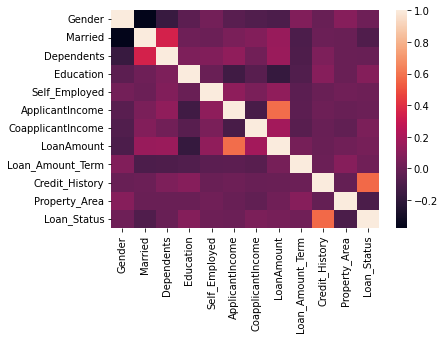

In [40]:
sns.heatmap(data_imputed.corr())

<AxesSubplot:>

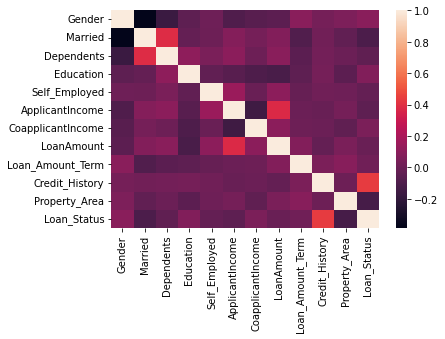

In [41]:
sns.heatmap(new_data.corr())

## Machine Learning

To do a more quantitative test of the synthetic data, we will be training a model on the original data and benchmarking the model against the original data and the synthetic data.

In [42]:
X = data_imputed.drop(["Loan_Status"], axis=1)
y = data_imputed["Loan_Status"]

training_data, test_data = train_test_split(X, test_size=0.2, random_state=seed)
training_target, test_target = train_test_split(y, test_size=0.2, random_state=seed)

clf = SVC()

clf.fit(training_data, training_target)

SVC()

In [43]:
test_results = clf.predict(test_data)

model_accuracy = list(test_results == test_target).count(True) / len(test_target)
print(f"The model was {round(model_accuracy * 100, 2)}% accurate on the authentic data")

The model was 85.65% accurate on the authentic data


In [46]:
synthetic_data = new_data.to_numpy()[:,:-1]
synthetic_target = new_data.to_numpy()[:,-1:].flatten()

synthetic_results = clf.predict(synthetic_data)
synthetic_accuracy = list(synthetic_results == synthetic_target).count(True) / len(synthetic_target)

print(f"The model was {round(synthetic_accuracy * 100, 2)}% accurate on the synthetic data")

The model was 72.39% accurate on the synthetic data


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


Our model leaves much to be desired in terms of accuracy. It was only able to hit 85.65% accuracy from our training to test split so it makes sense why the synthetic data didn't benchmark well. Next steps would be performing further processing on the data and tuning the hyperparameters of the models.

## Conclusion

Based on the analysis we did so far, there are a few important conclusions:

- The most important factors in determining whether an application gets approved or not is marital status, income, and dependents. This was seen visually in the exploratory data analysis section, and then confirmed later on by the heatmap. 
- Our synthetic data generator did not do a good job. When we ran our ML model on the synthetic data, it was only 72.739 accurate. When we previously ran the same model on the authentic data, it was 85.65% accurate.